# BeautyGAN
- Instance-level Facial Makeup Transfer with Deep Generative Adversarial Network
- 소스 이미지와 레퍼런스 이미지, 총 2장의 이미지가 필요합니다.
- 소스 이미지의 얼굴에 레퍼런스 이미지의 화장이 적용됩니다.
  - Face detection from random images
  - Facial landmarks detection
  - Face alignment
  - Inference
- 출처 : https://github.com/kairess/BeautyGAN

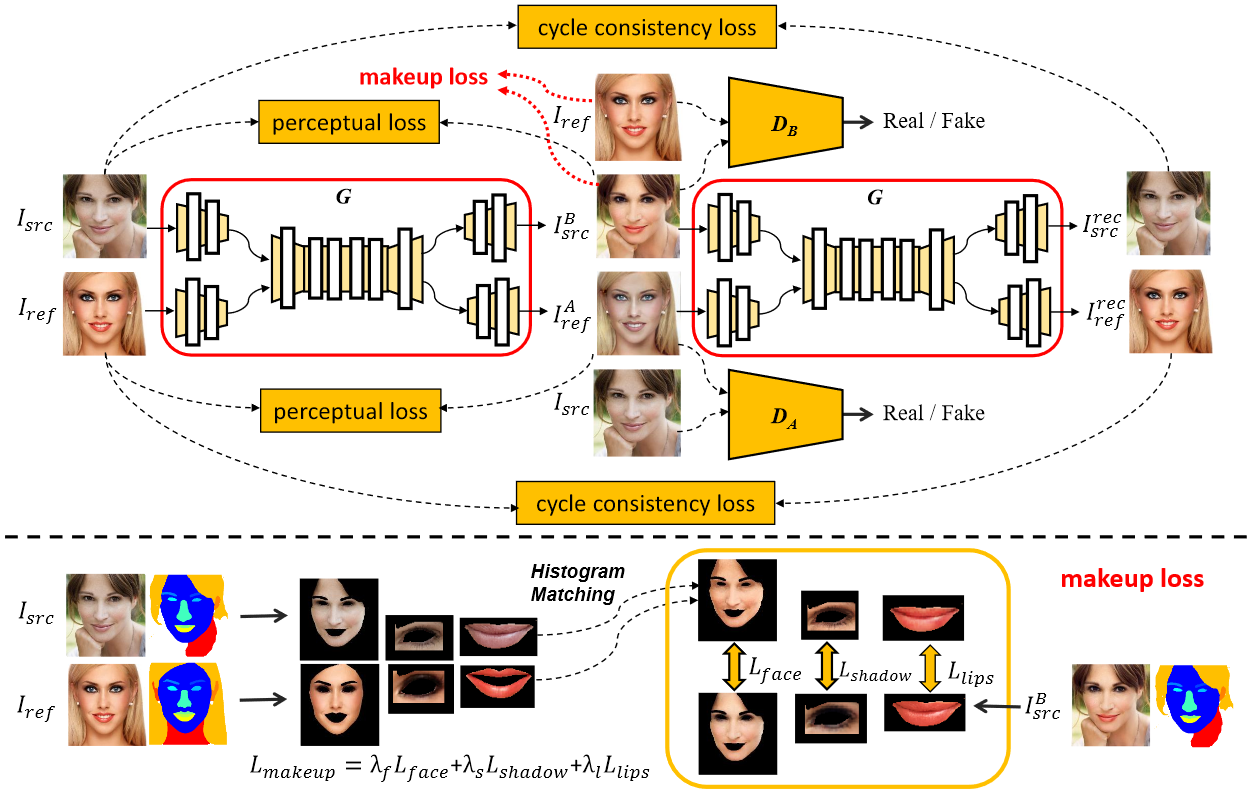

In [ ]:
# 텐서플로우 버전을 1.x로 설정합니다. 해당 모델을 텐서플로우 버전 1.x 에서만 돌아갑니다.
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# 필요한 라이브러리를 가져옵니다
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

import os  # chdir 사용시 필요함
import glob  # 파일 경로
import cv2
from google.colab.patches import cv2_imshow
import imageio
import skimage.io

In [ ]:
# 버전을 확인합니다.
print(tf.__version__)
print(dlib.__version__)

1.15.2
19.18.0


# Load Models


---



In [ ]:
# 얼굴 영역 인식 모델 로드
detector = dlib.get_frontal_face_detector()
# 5점 랜드마크 모델 로드
sp = dlib.shape_predictor('/content/shape_predictor_5_face_landmarks (1).dat')

# Load Images


---



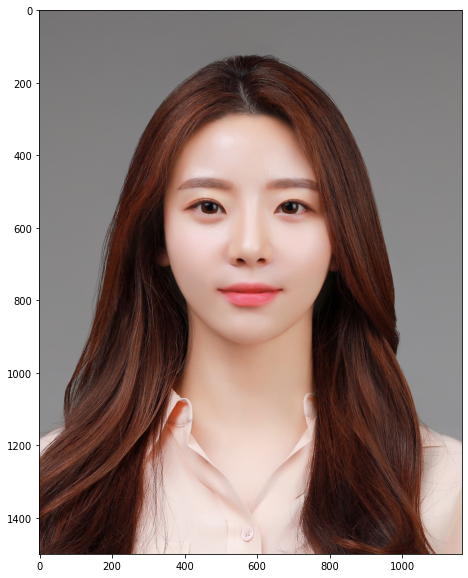

In [ ]:
# 이미지를 로드합니다
img = dlib.load_rgb_image('/content/source1.jpeg')

plt.figure(figsize=(16, 10))
plt.imshow(img)

# Find Faces


---



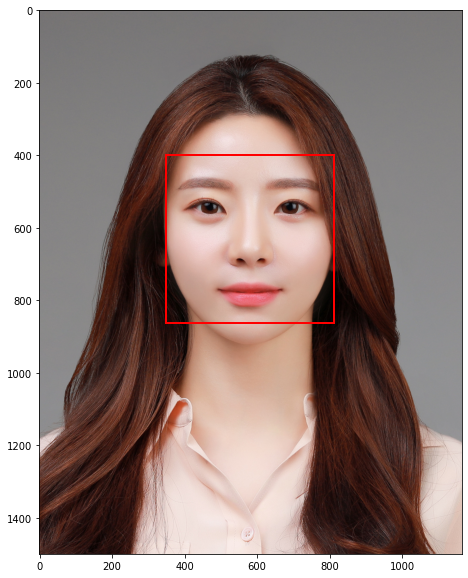

In [ ]:
img_result = img.copy()

# 이미지에서 얼굴 영역을 찾는다
dets = detector(img, 1)

# 얼굴을 찾지 못하면 'cannot find faces!'를 프린트함
if len(dets) == 0:
    print('cannot find faces!')

fig, ax = plt.subplots(1, figsize=(16, 10))

# 만약 얼굴을 찾게 되면 for문을 돌림, det 안에 dlib rectangle object 가 들어있음
for det in dets:
    x, y, w, h = det.left(), det.top(), det.width(), det.height()
    
    # 직사각형을 그립니다
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    # 그래프 영역에 패치를 추가한다
    ax.add_patch(rect)

ax.imshow(img_result)

# Find Landmarks 5points


---



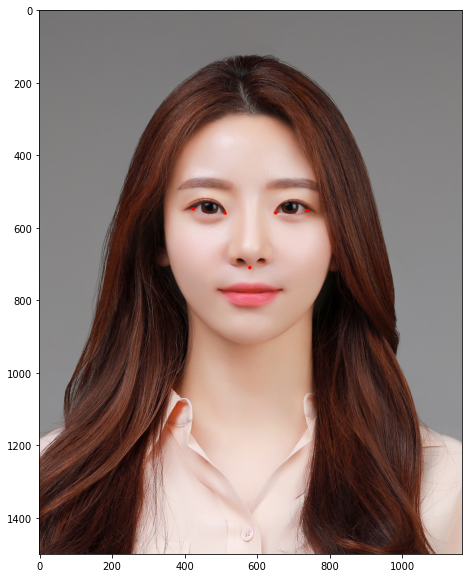

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))

objs = dlib.full_object_detections()

for detection in dets:
    # 얼굴의 랜드마크를 찾습니다.
    s = sp(img, detection)
    objs.append(s)
    
    for point in s.parts():
        # 5점의 랜드마크에 빨간색 원을 그립니다
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

# Align Faces


---


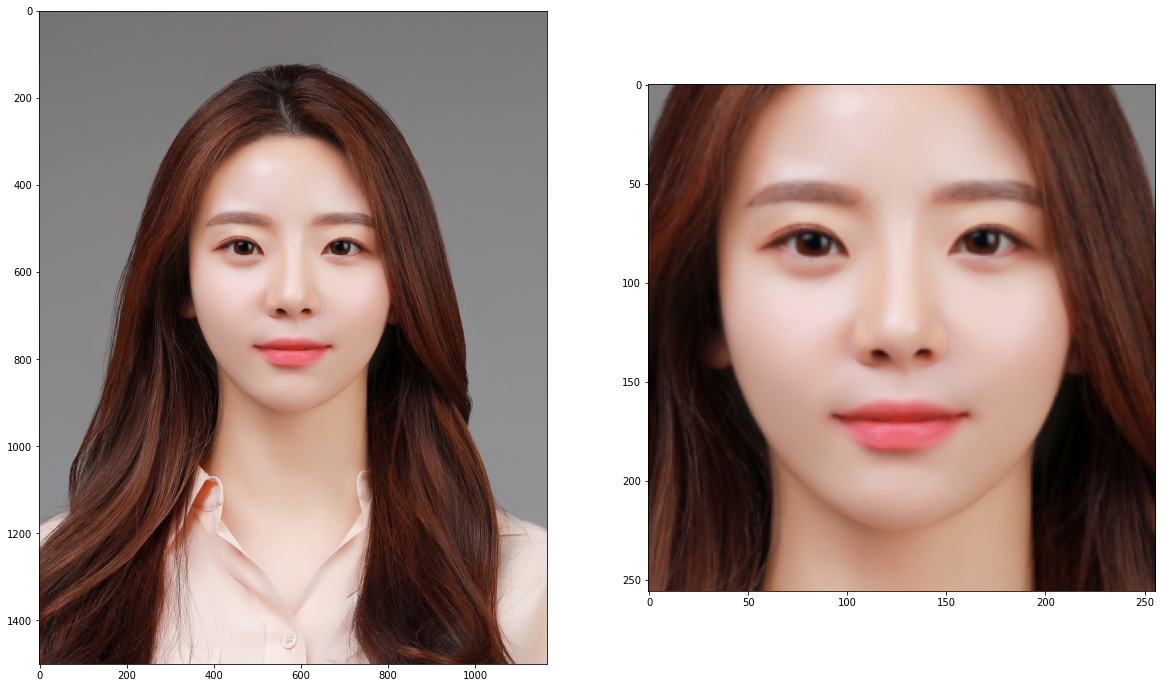

In [ ]:
# 얼굴을 수평으로 회전하여 얼굴 부분만 자른 이미지를 반환합니다.
# 패딩을 0.1로 지정하면 좀 더 타이트하게 얼굴을 짜르고, 패딩을 더 크게 설정하면 얼굴을 더 크게 짜릅니다.
faces = dlib.get_face_chips(img, objs, size=256, padding=0.3)

fig, axes = plt.subplots(1, len(faces)+1, figsize=(20, 16))

axes[0].imshow(img)

for i, face in enumerate(faces):
    axes[i+1].imshow(face)

- 위의 이미지는 이미 수평으로 얼굴이 가지런한 상태여서 Face Alignment 의 효과가 눈에 띄진 않습니다.
- 사람들이 여럿이 있는 사진으로 테스트를 해서 Face Alignment 의 효과를 다시 검증합니다.

# Functionalize


---



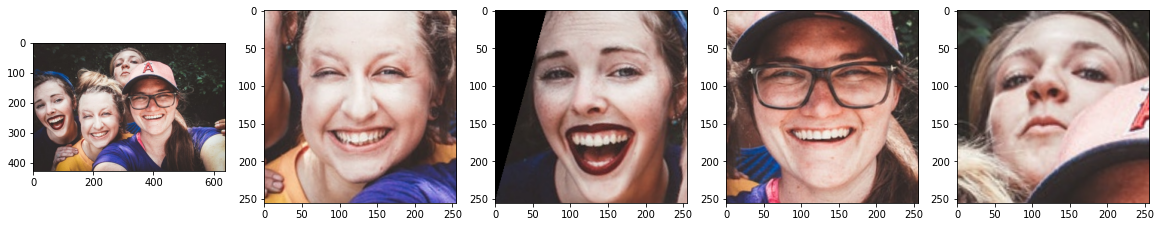

In [ ]:
# align faces 과정을 함수화 합니다.
def align_faces(img):
    dets = detector(img, 1)
    
    objs = dlib.full_object_detections()

    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
        
    faces = dlib.get_face_chips(img, objs, size=256, padding=0.35)
    
    return faces  # alignment를 완료한 얼굴 이미지들을 반환합니다.

# test - 여러 사람이 있는 이미지로 테스트 합니다.
test_img = dlib.load_rgb_image('/content/group_pic.jpeg')

test_faces = align_faces(test_img)

fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(20, 16))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

- 여러 사람이 있는 이미지에서 각각 사람들의 얼굴을 일자로 잘 정렬된 상태로 반환되는 것을 확인할 수 있습니다. (Face Alignment)

# Load BeautyGAN Pretrained


---


- https://drive.google.com/drive/folders/1pgVqnF2-rnOxcUQ3SO4JwHUFTdiSe5t9
- 이미 선행 학습된 모델을 위 링크에서 다운받습니다.

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph('/content/drive/MyDrive/BeautyGAN/model.meta')
saver.restore(sess, tf.train.latest_checkpoint('/content/drive/MyDrive/BeautyGAN'))
graph = tf.get_default_graph()

X = graph.get_tensor_by_name('X:0') # source : no-makeup image
Y = graph.get_tensor_by_name('Y:0') # reference : make-up image
Xs = graph.get_tensor_by_name('generator/xs:0') # output : generator 가 만든 이미지

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/BeautyGAN/model


# Preprocess and Postprocess Functions

In [ ]:
# 전처리 함수
def preprocess(img):
    return img.astype(np.float32) / 127.5 - 1.  # 0~255 이미지에서 -> -1 ~ 1 사이에의 값을 가진 float 형태로 바뀜

# 후처리 함수
def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8) # -1 ~ 1 사이의 값을 가진 float 형태에서 -> 0 ~ 255 이미지로 바뀜

# Load Images 1

In [ ]:
# 메이크업 안 한 이미지
img1 = dlib.load_rgb_image('/content/faceswap1.jpeg')
img1_faces = align_faces(img1)

# 메이크업 한 이미지
img2 = dlib.load_rgb_image('/content/아바타.jpg')
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img1_faces[0])  # 얼굴이 여러개 있더라도 0번 인덱스만 반환될 수 있게합니다.
axes[1].imshow(img2_faces[0])

# Run 1

In [ ]:
# 반환한 얼굴 이미지를 변수에 할당합니다.
src_img = img1_faces[0]
ref_img = img2_faces[0]

# 전처리한 소스 이미지를 X_img 에 할당합니다. (256, 256, 3)
X_img = preprocess(src_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
X_img = np.expand_dims(X_img, axis=0)

# 전처리한 레퍼런스 이미지를 Y_img 에 할당합니다. (256, 256, 3)
Y_img = preprocess(ref_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
Y_img = np.expand_dims(Y_img, axis=0)

# 결과 이미지
output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img) # 소스 이미지
axes[1].set_title('Reference')
axes[1].imshow(ref_img)  # 레퍼런스 이미지
axes[2].set_title('Result')
axes[2].imshow(output_img)  # 결과 이미지

In [ ]:
# Save the result_1, 결과 이미지를 저장합니다
cv2.imwrite('/content/drive/MyDrive/BeautyGAN/result_images/face_beauty1.jpg', cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

True

# Load Images 2

In [ ]:
# 메이크업 안 한 이미지
img3 = dlib.load_rgb_image('/content/faceswap2.jpeg')
img3_faces = align_faces(img3)


# 메이크업 한 이미지
img2 = dlib.load_rgb_image('/content/아바타.jpg')
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img3_faces[0]) # 얼굴이 여러개 있더라도 0번 인덱스만 반환될 수 있게합니다.
axes[1].imshow(img2_faces[0])

# Run 2

In [ ]:
# 반환한 얼굴 이미지를 변수에 할당합니다.
src_img = img3_faces[0]
ref_img = img2_faces[0]

# 전처리한 소스 이미지를 X_img 에 할당합니다. (256, 256, 3)
X_img = preprocess(src_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
X_img = np.expand_dims(X_img, axis=0)

# 전처리한 레퍼런스 이미지를 Y_img 에 할당합니다. (256, 256, 3)
Y_img = preprocess(ref_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
Y_img = np.expand_dims(Y_img, axis=0)

# 결과 이미지
output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img) # 소스 이미지
axes[1].set_title('Reference')
axes[1].imshow(ref_img)  # 레퍼런스 이미지
axes[2].set_title('Result')
axes[2].imshow(output_img)  # 결과 이미지

In [ ]:
# Save the result_2, 결과 이미지를 저장합니다
cv2.imwrite('/content/drive/MyDrive/BeautyGAN/result_images/face_beauty2.jpg', cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

True

# Load3

In [ ]:
# 메이크업 안 한 이미지
img4 = dlib.load_rgb_image('/content/faceswap3.jpeg')
img4_faces = align_faces(img4)


# 메이크업 한 이미지
img2 = dlib.load_rgb_image('/content/아바타.jpg')
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img4_faces[0]) # 얼굴이 여러개 있더라도 0번 인덱스만 반환될 수 있게합니다.
axes[1].imshow(img2_faces[0])

# Run 3

In [ ]:
# 반환한 얼굴 이미지를 변수에 할당합니다.
src_img = img4_faces[0]
ref_img = img2_faces[0]

# 전처리한 소스 이미지를 X_img 에 할당합니다. (256, 256, 3)
X_img = preprocess(src_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
X_img = np.expand_dims(X_img, axis=0)

# 전처리한 레퍼런스 이미지를 Y_img 에 할당합니다. (256, 256, 3)
Y_img = preprocess(ref_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
Y_img = np.expand_dims(Y_img, axis=0)

# 결과 이미지
output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img) # 소스 이미지
axes[1].set_title('Reference')
axes[1].imshow(ref_img)  # 레퍼런스 이미지
axes[2].set_title('Result')
axes[2].imshow(output_img)  # 결과 이미지

In [ ]:
# Save the result_3, 결과 이미지를 저장합니다
cv2.imwrite('/content/drive/MyDrive/BeautyGAN/result_images/face_beauty3.jpg', cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

True

# Load 4

In [ ]:
# 메이크업 안 한 이미지
img5 = dlib.load_rgb_image('/content/faceswap4.jpeg')
img5_faces = align_faces(img5)

# 메이크업 한 이미지
img2 = dlib.load_rgb_image('/content/아바타.jpg')
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img5_faces[0]) # 얼굴이 여러개 있더라도 0번 인덱스만 반환될 수 있게합니다.
axes[1].imshow(img2_faces[0])

# Run 4

In [ ]:
# 반환한 얼굴 이미지를 변수에 할당합니다.
src_img = img5_faces[0]
ref_img = img2_faces[0]

# 전처리한 소스 이미지를 X_img 에 할당합니다. (256, 256, 3)
X_img = preprocess(src_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
X_img = np.expand_dims(X_img, axis=0)

# 전처리한 레퍼런스 이미지를 Y_img 에 할당합니다. (256, 256, 3)
Y_img = preprocess(ref_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
Y_img = np.expand_dims(Y_img, axis=0)

# 결과 이미지
output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img) # 소스 이미지
axes[1].set_title('Reference')
axes[1].imshow(ref_img)  # 레퍼런스 이미지
axes[2].set_title('Result')
axes[2].imshow(output_img)  # 결과 이미지

In [ ]:
# Save the result_4, 결과 이미지를 저장합니다
cv2.imwrite('/content/drive/MyDrive/BeautyGAN/result_images/face_beauty4.jpg', cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

True

# Load 5

In [ ]:
# 메이크업 안 한 이미지
img6 = dlib.load_rgb_image('/content/faceswap5.jpeg')
img6_faces = align_faces(img6)

# 메이크업 한 이미지
img2 = dlib.load_rgb_image('/content/아바타.jpg')
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img6_faces[0]) # 얼굴이 여러개 있더라도 0번 인덱스만 반환될 수 있게합니다.
axes[1].imshow(img2_faces[0])

# Run 5

In [ ]:
# 반환한 얼굴 이미지를 변수에 할당합니다.
src_img = img6_faces[0]
ref_img = img2_faces[0]

# 전처리한 소스 이미지를 X_img 에 할당합니다. (256, 256, 3)
X_img = preprocess(src_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
X_img = np.expand_dims(X_img, axis=0)

# 전처리한 레퍼런스 이미지를 Y_img 에 할당합니다. (256, 256, 3)
Y_img = preprocess(ref_img)
# 배열에 차원을 추가합니다. (1, 256, 256, 3)
Y_img = np.expand_dims(Y_img, axis=0)

# 결과 이미지
output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img) # 소스 이미지
axes[1].set_title('Reference')
axes[1].imshow(ref_img)  # 레퍼런스 이미지
axes[2].set_title('Result')
axes[2].imshow(output_img)  # 결과 이미지

In [ ]:
# Save the result_5, 결과 이미지를 저장합니다
cv2.imwrite('/content/drive/MyDrive/BeautyGAN/result_images/face_beauty5.jpg', cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

True